### <b>Dataset Download</b>

* This facial identity classification dataset has total <b>307 identities</b>. (train: 4,263 / test: 1,215)
* <b>Original dataset</b>: [CelebA Mask HQ](https://github.com/switchablenorms/CelebAMask-HQ)

<pre>
<b>Dataset/</b>
    <b>train/</b>
        identity 1/
        identity 2/
        ...
    <b>test/</b>
        identity 1/
        identity 2/
        ...
</pre>

### <b>Load Dataset</b>

* Set the image directory path and initialize PyTorch data loaders.

## Data Augmentation for transfer learning

Because the faces provided in the Youtube Faces dataset is aligned, we apply random rotation to the images for better results during inference.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os

batch_size = 64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

### Define Sampler

In [2]:
from torch.utils.data.sampler import RandomSampler

transforms_train = transforms.Compose([
    transforms.Resize((256, 256)),
#     transforms.RandomRotation(50), # added
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.CenterCrop(160),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

transforms_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = '/home/ubuntu/visual_search_assistant/youtube_split_'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)


In [3]:
train_size = len(train_dataset)
test_size = len(test_dataset)

train_indices = list(range(train_size))
test_indices = list(range(test_size)) 

np.random.shuffle(train_indices)
np.random.shuffle(test_indices)

from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

train_subset_size = 10000
test_subset_size = 1000

train_sampler = SubsetRandomSampler(train_indices[:train_subset_size])
test_sampler = SubsetRandomSampler(test_indices[:test_subset_size])

# train_sampler = None
# test_sampler = None

In [4]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=0,sampler=train_sampler)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=0,sampler=test_sampler)

# print('Train dataset size:', len(train_dataset))
# print('Test dataset size:', len(test_dataset))

class_names = train_dataset.classes
print('First 200 Class names:', class_names[:200])

First 200 Class names: ['AJ_Cook', 'Aaron_Eckhart', 'Aaron_Sorkin', 'Aaron_Tippin', 'Abba_Eban', 'Abdel_Aziz_Al-Hakim', 'Abdoulaye_Wade', 'Abdulaziz_Kamilov', 'Abdullah_Gul', 'Abdullatif_Sener', 'Abel_Pacheco', 'Adam_Ant', 'Adam_Sandler', 'Adrian_Nastase', 'Adrianna_Zuzic', 'Agbani_Darego', 'Agnes_Bruckner', 'Ahmad_Masood', 'Ahmed_Ahmed', 'Aidan_Quinn', 'Aishwarya_Rai', 'Akbar_Al_Baker', 'Akiko_Morigami', 'Akmal_Taher', 'Al_Davis', 'Al_Gore', 'Al_Leiter', 'Al_Pacino', 'Alan_Ball', 'Alan_Dershowitz', 'Alanis_Morissette', 'Alastair_Campbell', 'Albert_Brooks', 'Alberto_Acosta', 'Alberto_Gonzales', 'Alberto_Ruiz_Gallardon', 'Alec_Baldwin', 'Alejandro_Gonzalez_Inarritu', 'Alejandro_Toledo', 'Alek_Wek', 'Aleksander_Kwasniewski', 'Alex_Ferguson', 'Alex_Holmes', 'Alex_Sink', 'Alexander_Downer', 'Alexander_Lukashenko', 'Alexander_Payne', 'Alexandra_Pelosi', 'Alexandre_Despatie', 'Alexandre_Herchcovitch', 'Alexis_Bledel', 'Alexis_Dennisoff', 'Alfonso_Cuaron', 'Alfred_Sant', 'Alfredo_Moreno', 'Al

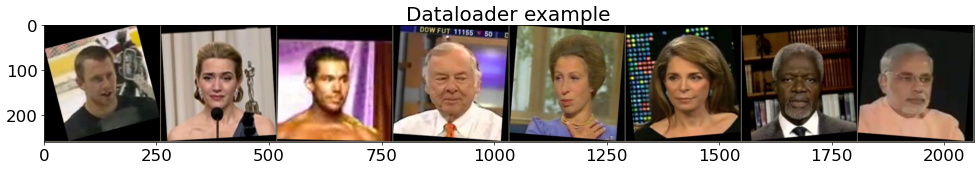

['Eric_Fehr', 'Kate_Winslet', 'Paul_Krueger', 'T_Boone_Pickens', 'Princess_Anne', 'Queen_Noor', 'Kofi_Annan', 'Narendra_Modi']


In [5]:
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()


# load a batch of train image
iterator = iter(train_dataloader)

# visualize a batch of train image
inputs, classes = next(iterator)

demo_count = 8
out = torchvision.utils.make_grid(inputs[:demo_count])
imshow(out,title='Dataloader example')
print([class_names[x] for x in classes[:demo_count]])

### <b>Define Model</b>

* We focus on a transfer learning method.

In [6]:
from facenet_pytorch import InceptionResnetV1

model = InceptionResnetV1(pretrained='vggface2',num_classes=1004,classify=True).to(device)

# model = InceptionResnetV1(num_classes=1004,classify=True).to(device)

In [7]:
# model = models.resnet18(pretrained=True)
# num_features = model.fc.in_features
# model.fc = nn.Linear(num_features, 307) # multi-class classification (num_of_class == 307)
# model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

### <b>Training Phase</b>


In [ ]:
torch.cuda.empty_cache()
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

from tqdm import tqdm
from PIL import ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True
import warnings
warnings.filterwarnings('ignore')

num_epochs = 30
start_time = time.time()

for epoch in range(num_epochs):
    """ Training Phase """
    model.train()

    running_loss = 0.
    running_corrects = 0
    # load a batch data of images
    for i, (inputs, labels) in tqdm(enumerate(train_dataloader)):
#         import pdb;pdb.set_trace()
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # get loss value and update the network weights
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

    """ Test Phase """
    model.eval()

    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0

        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / len(test_dataset) * 100.
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

157it [02:38,  1.01s/it]


[Train #0] Loss: 0.1014 Acc: 1.3765% Time: 158.2227s
[Test #0] Loss: 0.0307 Acc: 0.1199% Time: 165.3492s


157it [02:40,  1.02s/it]


[Train #1] Loss: 0.0338 Acc: 2.3814% Time: 325.4299s
[Test #1] Loss: 0.0271 Acc: 0.1586% Time: 332.7556s


157it [02:43,  1.04s/it]


[Train #2] Loss: 0.0142 Acc: 2.6915% Time: 496.0435s
[Test #2] Loss: 0.0255 Acc: 0.1820% Time: 503.4720s


157it [02:42,  1.03s/it]


[Train #3] Loss: 0.0060 Acc: 2.8119% Time: 665.9433s
[Test #3] Loss: 0.0239 Acc: 0.2048% Time: 673.2817s


157it [02:35,  1.01it/s]


[Train #4] Loss: 0.0028 Acc: 2.8495% Time: 828.5332s
[Test #4] Loss: 0.0233 Acc: 0.2112% Time: 835.1537s


157it [02:35,  1.01it/s]


[Train #5] Loss: 0.0016 Acc: 2.8618% Time: 990.4308s
[Test #5] Loss: 0.0228 Acc: 0.2182% Time: 997.1526s


157it [02:35,  1.01it/s]


[Train #6] Loss: 0.0010 Acc: 2.8699% Time: 1152.4957s
[Test #6] Loss: 0.0224 Acc: 0.2206% Time: 1159.2436s


157it [02:35,  1.01it/s]


[Train #7] Loss: 0.0007 Acc: 2.8719% Time: 1314.5659s
[Test #7] Loss: 0.0225 Acc: 0.2235% Time: 1321.2729s


157it [02:34,  1.02it/s]


[Train #8] Loss: 0.0005 Acc: 2.8719% Time: 1475.6581s
[Test #8] Loss: 0.0224 Acc: 0.2258% Time: 1482.2381s


157it [02:33,  1.02it/s]


[Train #9] Loss: 0.0004 Acc: 2.8719% Time: 1635.7741s
[Test #9] Loss: 0.0223 Acc: 0.2241% Time: 1642.3732s


157it [02:34,  1.02it/s]


[Train #10] Loss: 0.0004 Acc: 2.8719% Time: 1796.5141s
[Test #10] Loss: 0.0223 Acc: 0.2223% Time: 1803.1370s


157it [02:33,  1.02it/s]


[Train #11] Loss: 0.0003 Acc: 2.8719% Time: 1957.0676s
[Test #11] Loss: 0.0223 Acc: 0.2241% Time: 1963.6750s


157it [02:35,  1.01it/s]


[Train #12] Loss: 0.0003 Acc: 2.8719% Time: 2118.7440s
[Test #12] Loss: 0.0223 Acc: 0.2217% Time: 2125.3871s


157it [02:35,  1.01it/s]


[Train #13] Loss: 0.0002 Acc: 2.8719% Time: 2280.8514s
[Test #13] Loss: 0.0222 Acc: 0.2241% Time: 2287.5015s


157it [02:35,  1.01it/s]


[Train #14] Loss: 0.0002 Acc: 2.8719% Time: 2442.6150s
[Test #14] Loss: 0.0222 Acc: 0.2247% Time: 2449.2177s


157it [02:34,  1.02it/s]


[Train #15] Loss: 0.0002 Acc: 2.8719% Time: 2603.7979s


### <b>Final Test Phase</b>

* Save the trained model file.

In [ ]:
save_path = 'finetuned_youtube_dataset.pth'
torch.save(model.state_dict(), save_path)

* Load from the trained model file.

In [ ]:
# model = models.resnet18(pretrained=True)
# num_features = model.fc.in_features
# model.fc = nn.Linear(num_features, 307) # multi-class classification (num_of_class == 307)
# model.load_state_dict(torch.load(save_path))
model.to(device)

* Evaluate the trained model.

In [ ]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Original Image Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in labels[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in labels[4:8]])
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in preds[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in preds[4:8]])

    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.
    print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))